In [35]:
import sqlalchemy as sql
import psycopg2 
import pandas.io.sql as sqlio
import pandas as pd
from functools import reduce
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
!pip install sea
!pip install kneed
!pip install mpl_toolkits
!pip install pandasql

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=9ba8951599603506117baa3fed77893c6ba14aaf38e5bfd5f258882f2840610e
  Stored in directory: /home/jovyan/.cache/pip/wheels/63/e8/ec/75b1df467ecf57b6ececb32cb16f4e86697cbfe55cb0c51f07
Successfully built pandasql


In [48]:
!pip install flask_sqlalchemy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 21.0 MB/s eta 0:00:00
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dbt-core 1.0.3 requires Jinja2==2.11.3, but you have jinja2 3.1.2 which is incompatible.


In [36]:
import sea
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from pandasql import sqldf

In [4]:
engine = sqlalchemy.create_engine('postgresql')

In [5]:
query = ''' with equity_avg as (
select user_account , percentile_cont(0.5) within group (order by avg_equity) as median_equity
from (
select user_account, sum(max_equity_month)/count(month_of) as avg_equity
from (
select a.user_account,date_trunc('month', asof) as month_of, max(db.equity) as max_equity_month
from equity db 
left join accounts A on a.id = db.account_id
and asof >= current_date - 90
and db.equity > 0
and a.user_account is not NULL
group by 1, 2
)query1
group by 1
)query2
group by 1
),

median_orders as (
select orders.account, count(orders.id)/count(distinct date_trunc('day', filled_at)) as orders_per_day
from orders 
left join accounts A on a.user_account = orders.account 
left join assets ast ON ast.id::uuid=orders.asset_id::uuid
where filled_at > current_date - 180
and filled_at is not NULL
and ast.class = 'global'
group by 1

)


select mo.account, mo.orders_per_day, ea.median_equity
from median_orders mo
left join equity_avg ea on ea.user_account = mo.account 


'''

In [6]:
df = pd.read_sql_query(query, engine)
df = df.dropna()

In [7]:
df.describe()

,orders_per_day,median_equity
count,3530.000000,3.530000e+03
mean,21.547025,3.215205e+04
std,133.725878,4.610469e+05
min,1.000000,1.000000e-02
25%,1.000000,1.669688e+02
50%,2.000000,2.039418e+03
75%,5.000000,2.106775e+04
max,4661.000000,2.418932e+07


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


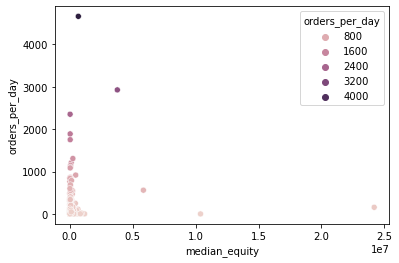

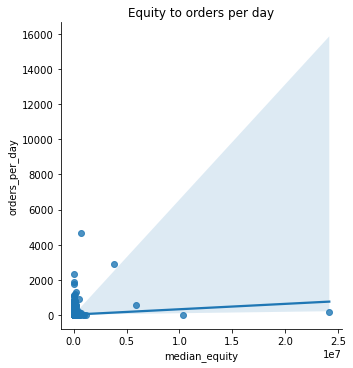

In [52]:
#Plotting to see where the distribution lies
sns.scatterplot('median_equity', 'orders_per_day', hue='orders_per_day', data=df);
sns.lmplot('median_equity', 'orders_per_day', data=df);
plt.title('Equity to orders per day');

In [53]:
data = df.reset_index().drop('index',axis=1)

#### Feature scaling for a ML model is very important and standardizing is one of the methods of doing so. We will standardize all variables in the dataset to get them around the same scale between 0-1

In [54]:
col_names = ['orders_per_day', 'median_equity']
features = data[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()
data2 = scaled_features
data2.head()

,orders_per_day,median_equity
0,-0.146193,-0.065906
1,-0.138714,-0.050763
2,-0.146193,-0.069735
3,-0.138714,-0.066009
4,2.546263,-0.013634


#### Checking for dataset variance by each component. We will do so by using the Principal Component Analysis(PCA) test. PCA is usually done to check which of the components in a dataset cover maximum of the variance, but in this case, we are using it to check by how much do the components differ. 
#### Greater the variance, greater is the impact of the component on the model. 

#### In this case as we see below, the variance doesn't differ by a lot, only 0.10, hence both componenets will have a similar quantitative impact on the model, which is good news


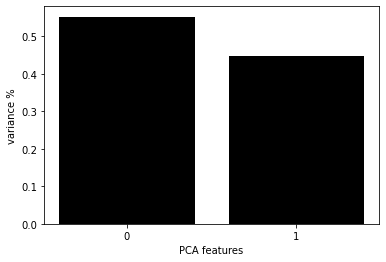

In [55]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data2)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

#### Building the model with the above components, and a cluster size of 9

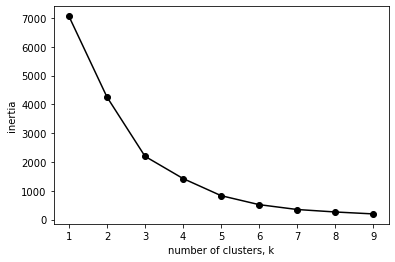

In [56]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [57]:
model = KMeans(n_clusters=9)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 

0.924763366229106


#### A silhouette coefficient, or a silhouette score is a metric used to evaluate the quality of clusters created by the algorithm. Silhouette scores range from -1 to +1. The higher the silhouette score, the better the model. This is a really good silhouette score of the model.

#### Let's visualize what the cluster looks like

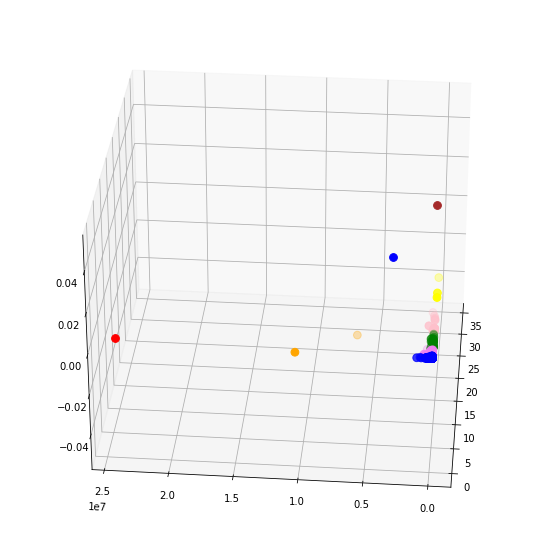

In [58]:
model = KMeans(n_clusters=9)

clusters = model.fit_predict(PCA_components.iloc[:,:2])
data2["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data2["orders_per_day"][data2.label == 0], data["median_equity"][data2.label == 0], c='blue', s=60)

ax.scatter(data2["orders_per_day"][data2.label == 1], data["median_equity"][data2.label == 1], c='red', s=60)
ax.scatter(data2["orders_per_day"][data2.label == 2], data["median_equity"][data2.label == 2], c='blue', s=60)
ax.scatter(data2["orders_per_day"][data2.label == 3], data["median_equity"][data2.label == 3], c='green', s=60)
ax.scatter(data2["orders_per_day"][data2.label == 4], data["median_equity"][data2.label == 4], c='orange', s=60)
ax.scatter(data2["orders_per_day"][data2.label == 5], data["median_equity"][data2.label == 5], c='yellow', s=60)

ax.scatter(data2["orders_per_day"][data2.label == 6], data["median_equity"][data2.label == 6], c='brown', s=60)
ax.scatter(data2["orders_per_day"][data2.label == 7], data["median_equity"][data2.label == 7], c='violet', s=60)
ax.scatter(data2["orders_per_day"][data2.label == 8], data["median_equity"][data2.label == 8], c='pink', s=60)

ax.view_init(30, 185)
plt.show()

#### The above graph shows us how congested the clusters are

In [17]:
df2 = df.drop(['account'],axis=1)

In [18]:
pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df2)
frame['cluster'] = pred
frame.head()

,orders_per_day,median_equity,cluster
1,2,1770.815578,0
2,3,8751.347500,0
3,2,5.300000,0
4,3,1722.957565,0
5,362,25867.137500,5


In [19]:
df2.columns = df2.columns.str.strip()

In [20]:
avg_df = df2.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,orders_per_day,median_equity
0,0,6.848653,1.814947e+04
1,1,159.000000,2.418932e+07
2,2,910.866667,8.621415e+04
3,3,4661.000000,6.759789e+05
4,4,3.000000,1.038647e+07
5,5,271.351648,5.772459e+04
6,6,1999.000000,2.526297e+04
7,7,2927.000000,3.776977e+06
8,8,563.000000,5.847455e+06


<AxesSubplot:xlabel='cluster', ylabel='orders_per_day'>

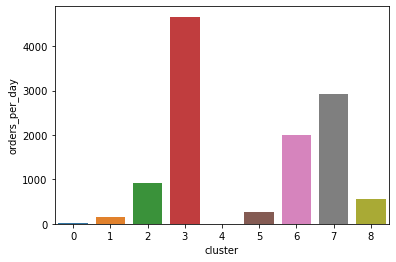

In [21]:
sns.barplot(x='cluster',y='orders_per_day',data=avg_df)

<AxesSubplot:xlabel='cluster', ylabel='median_equity'>

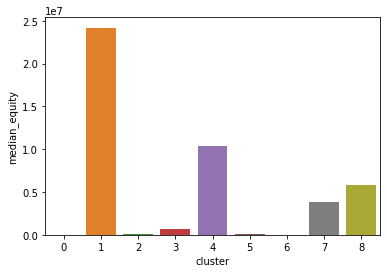

In [22]:
sns.barplot(x='cluster',y='median_equity',data=avg_df)

In [23]:
df_sort2 = avg_df.sort_values(['orders_per_day','median_equity'],ascending=[False, False])

Sorting the dataframe according to Trading Volume in descending order\
We see that clusters are in groups of three's.\
6,4,7 HIGH FREQ \
3,8,5 MED FREQ \
1,0,2 LOW FREQ \
This will allow us to also understand within these groups, which clusters belong to HIGH, MED, LOW AUM

In [24]:
df_sort2

,cluster,orders_per_day,median_equity
3,3,4661.000000,6.759789e+05
7,7,2927.000000,3.776977e+06
6,6,1999.000000,2.526297e+04
2,2,910.866667,8.621415e+04
8,8,563.000000,5.847455e+06
5,5,271.351648,5.772459e+04
1,1,159.000000,2.418932e+07
0,0,6.848653,1.814947e+04
4,4,3.000000,1.038647e+07


#### Looking at the above data we can conclude the following clusters: 
0: LOW AUM, LOW FREQ \
1: HIGH AUM, MED FREQ \
2: LOW AUM, MED FREQ \
3: HIGH AUM, HIGH FREQ \
4: HIGH AUM, LOW FREQ \
5: MED AUM, LOW FREQ\
6: MED AUM, HIGH FREQ \
7: LOW AUM , HIGH FREQ \
8: MED AUM, MED FREQ \

In [25]:
frame2 = pd.DataFrame(df)
frame2['cluster'] = pred
frame2.head()

,account,orders_per_day,median_equity,cluster
1,578054367,2,1770.815578,0
2,578073646,3,8751.347500,0
3,578171219,2,5.300000,0
4,578197586,3,1722.957565,0
5,578222371,362,25867.137500,5


#### Grouping by distinct cluster gives us a count of the following:

In [51]:
frame2.groupby(['cluster']).size()

cluster
0    3416
1       1
2      15
3       1
4       1
5      91
6       3
7       1
8       1
dtype: int64